In [1]:
import numpy as np
from wavefunctions import *
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

In [15]:
def information(datapack, electronic_structure_data, Z):
    
    df = datapack[datapack['Z']== Z]
    e_struct = np.array(electronic_structure_data[electronic_structure_data['Z']==Z].drop(columns='Z'))[0]
    
    def creating_Rij(df):
        n = len(df)
        sto = np.array(df['sto'])
        zeff = np.array(df['zeff'])
        coeff = np.array(df['coeff'])
        f = []
        for i in range(n):
            f.append(lambda r, z=zeff[i], c=coeff[i], sto = sto[i]: c*Sr_orb[sto](z,r))

        def Rij(r,f):
            res=0
            for func in f:
                res = res + func(r)
            return res

        return (lambda r, f=f: Rij(r,f))
    
    def creating_Kij(df):
        n = len(df)
        sto = np.array(df['sto'])
        zeff = np.array(df['zeff'])
        coeff = np.array(df['coeff'])
        f = []
        for i in range(n):
            f.append(lambda k, z=zeff[i], c=coeff[i], sto = sto[i]: c*Sk_orb[sto](z,k))

        def Kij(k,f):
            res=0
            for func in f:
                res = res + func(k)
            return res

        return (lambda k, f=f: Kij(k,f))  
    
    def return_pr(el_struct,df):
        name_of_orbitals = df['orb'].unique()
        R = []
        for i in name_of_orbitals:
            R.append(creating_Rij(df[df['orb']==i]))

        def pr(R, el_struct,r):
            res = 0
            for i in range(len(R)):
                res = res + el_struct[i]*R[i](r)**2
            return 1/(4*np.pi*sum(el_struct))*res

        return lambda r: pr(R,el_struct,r)
    
    def return_nk(el_struct,df):
        name_of_orbitals = df['orb'].unique()
        R = []
        for i in name_of_orbitals:
            R.append(creating_Kij(df[df['orb']==i]))

        def nk(R, el_struct,k):
            res = 0
            for i in range(len(R)):
                res = res + el_struct[i]*R[i](k)**2
            return 1/(4*np.pi*sum(el_struct))*res

        return lambda k: nk(R,el_struct,k)
    
    Pr = return_pr(e_struct,df)
    Nk = return_nk(e_struct,df)
    
    def information_entropy(pr):
        return -4*np.pi*quad(lambda r: pr(r)*np.log(pr(r))*r**2 ,0,250)[0] 
    
    Sr = information_entropy(Pr)
    Sk = information_entropy(Nk)
    S = Sr + Sk
    
    def Smaximum(pr,nk):
        r2 = 4*np.pi*quad(lambda r: pr(r)*r**4,0,np.inf)[0]
        k2 = 4*np.pi*quad(lambda k: nk(k)*k**4,0,np.inf)[0]
        return 3*(1+np.log(np.pi)) + 3/2 * np.log(4/9 * r2*k2)
    
    Smax = Smaximum(Pr,Nk)
    Omega = 1 - S/Smax
    
    def Onicescu(pr, nk):
        er = 4*np.pi*quad(lambda r: pr(r)**2 * r**2 ,0,np.inf)[0]
        ek = 4*np.pi*quad(lambda k: nk(k)**2 * k**2 ,0,np.inf)[0]
        return 1/(er*ek)
        
    O = Onicescu(Pr,Nk)
    
    return [Sr,Sk,S,Smax,Omega,O]

In [16]:
datapack = pd.read_excel('df.xlsx')
electronic_structure_data = pd.read_excel('electronic_structures.xlsx')

In [18]:
s = np.zeros([9,6])
for i in range(9):
    s[i] = information(datapack,electronic_structure_data, i+2)

In [19]:
s

array([[2.69851098e+00, 3.91341876e+00, 6.61192974e+00, 7.04929938e+00,
        6.20444120e-02, 1.00361326e+02],
       [3.70143692e+00, 3.99681902e+00, 7.69825594e+00, 1.03578387e+01,
        2.56770053e-01, 9.15712669e+00],
       [3.62385902e+00, 4.19018752e+00, 7.81404655e+00, 1.03950284e+01,
        2.48290028e-01, 8.45433890e+00],
       [3.40544523e+00, 4.70590170e+00, 8.11134693e+00, 1.03738438e+01,
        2.18096291e-01, 1.59653159e+01],
       [3.10602495e+00, 5.15657609e+00, 8.26260104e+00, 1.02624186e+01,
        1.94868052e-01, 2.57121303e+01],
       [2.80168815e+00, 5.54933681e+00, 8.35102496e+00, 1.01519723e+01,
        1.77398766e-01, 3.74319820e+01],
       [2.55053873e+00, 5.86735300e+00, 8.41789174e+00, 1.01112708e+01,
        1.67474408e-01, 4.84837692e+01],
       [2.29882700e+00, 6.16332423e+00, 8.46215123e+00, 1.00532785e+01,
        1.58269488e-01, 6.11450042e+01],
       [2.05513774e+00, 6.43706707e+00, 8.49220481e+00, 9.99076600e+00,
        1.49994624e-01, 

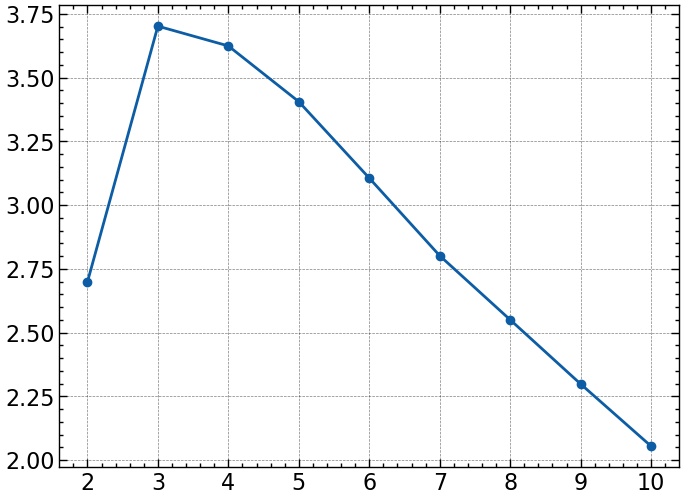

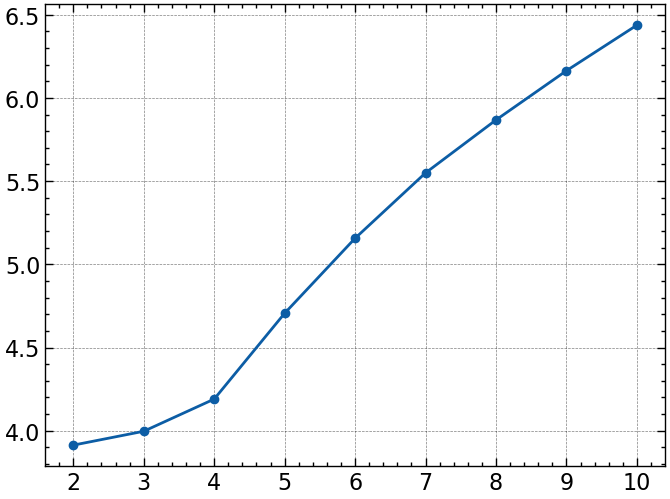

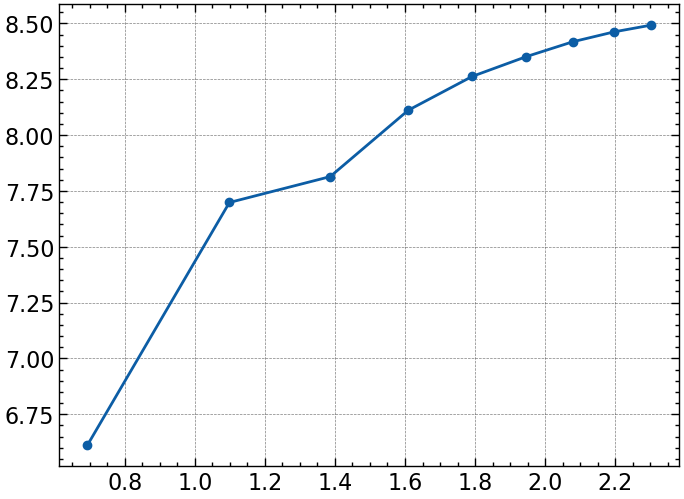

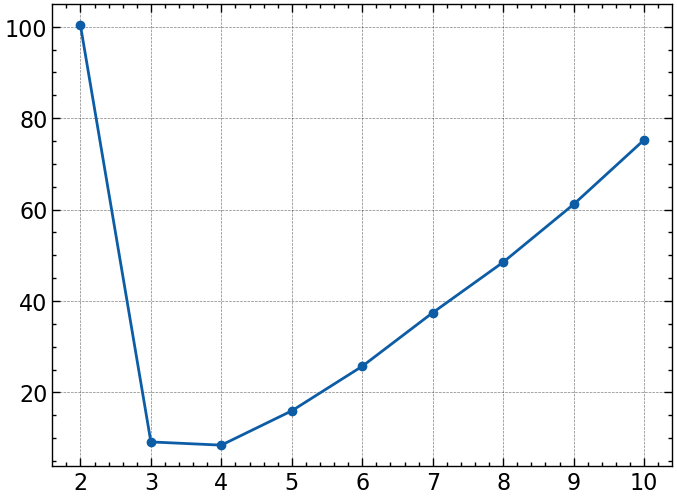

In [22]:
z = np.arange(2,11)
plt.plot(z,s[:,0],'o-')
plt.show()
plt.plot(z,s[:,1],'o-')
plt.show()
plt.plot(np.log(z),s[:,2],'o-')
plt.show()
plt.plot(z,s[:,-1],'o-')
plt.show()